# promis dataset preprocessing
### Import

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import json
import pandas as pd
import numpy as np
from liriscat.dataset.preprocessing_utilities import *
from liriscat.utils import utils
import torch
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.
CUDA is not available. Skipping CUDA seed setting.


### Load and merge dataset

In [3]:
raw_data = pd.read_csv('../1-raw_data/promis_flipped.csv', encoding="ISO-8859-15", low_memory=False)

raw_data = raw_data.drop(columns=['Unnamed: 0','Unnamed: 0.1'])

raw_data =  raw_data.rename(columns={"caseid": "user_id", "dimension_id":"supdimension_id", "subdimension_id":"dimension_id","question_id":"item_id"})
raw_data.head()

,user_id,item_id,correct,supdimension_id,dimension_id
0,84,EDANG55,NaN,Emotional Distress,Anger Items
1,85,EDANG55,NaN,Emotional Distress,Anger Items
2,86,EDANG55,NaN,Emotional Distress,Anger Items
3,87,EDANG55,NaN,Emotional Distress,Anger Items
4,88,EDANG55,NaN,Emotional Distress,Anger Items


In [4]:
print(len(raw_data))
all_data = raw_data.dropna(subset=['user_id','item_id','correct','dimension_id'])
print(len(all_data))

21957187
2256115


In [5]:
stat_unique(all_data, None)
stat_unique(all_data, ['user_id', 'item_id'])
stat_unique(all_data, 'user_id')
stat_unique(all_data, 'item_id')
stat_unique(all_data, 'dimension_id')

Total length: 2256115
Number of unique [user_id,item_id]: 2256115
Number of unique user_id: 21096
Number of unique item_id: 941
Number of unique dimension_id: 29


### Clean Nan values

In [6]:
cleaned_data = all_data.dropna(subset=['user_id','item_id','correct','dimension_id'], axis='index')

### Remove duplicated user and id rows

In [7]:
unduplicated_data = remove_duplicates(cleaned_data,key_attrs=['user_id','item_id','dimension_id'],agg_attrs=[])

### Filter Data

In [8]:
filtered_data_0 = unduplicated_data
filtered_q_nb = 1
filtered_u_nb = 0
filtered_d_nb = 0
while filtered_q_nb!=0 or filtered_u_nb!=0 or filtered_d_nb!=0 : 
    # filter items
    filtered_data_1, filtered_q_nb = densify(filtered_data_0,'item_id','user_id',1835)
    # filter users
    min_nb_users_logs = 102
    filtered_data_2, filtered_u_nb = densify(filtered_data_1,'user_id','item_id',min_nb_users_logs)
    # filter knowledges
    filtered_data_3, filtered_d_nb = densify(filtered_data_2,'dimension_id','item_id',1)
    filtered_data_0 = filtered_data_3
    
stat_unique(filtered_data_0, None)
stat_unique(filtered_data_0, ['user_id', 'item_id'])
stat_unique(filtered_data_0, 'user_id')
stat_unique(filtered_data_0, 'item_id')
stat_unique(filtered_data_0, 'dimension_id')
stat_unique(filtered_data_0, 'supdimension_id')

filter 151 item_id
filter 4217 user_id
filter 0 dimension_id
filter 0 item_id
filter 0 user_id
filter 0 dimension_id
Total length: 1805842
Number of unique [user_id,item_id]: 1805842
Number of unique user_id: 16879
Number of unique item_id: 790
Number of unique dimension_id: 15
Number of unique supdimension_id: 6


### Encoding

In [9]:
# renumber the users
u_enc_data, u2n = encode_attr(filtered_data_0, "user_id")

In [10]:
# renumber the items
q_enc_data, q2n = encode_attr(u_enc_data, "item_id")

In [11]:
# renumber the dimensions
d_enc_data, d2n = encode_attr(q_enc_data, "dimension_id")

In [12]:
# renumber the subdimensions
sd_enc_data, sd2n = encode_attr(d_enc_data, "supdimension_id")

### Maps creation

In [13]:
q2k, k2q = create_q2k(d_enc_data)

In [14]:
# Create an empty dictionary to store the item ID and response range
promis_metadata = pd.read_csv("../1-raw_data/promis_complete_metadata.csv")

[response_range_dict, min_response_dict, max_response_dict] = rescaling_dict(promis_metadata,q2n)

'clinic01' were removed from dataset
'clinic02' were removed from dataset
'clinic03' were removed from dataset
'clinic04' were removed from dataset
'clinic05' were removed from dataset
'clinic06' were removed from dataset
'clinic07' were removed from dataset
'clinic08' were removed from dataset
'clinic09' were removed from dataset
'clinic10' were removed from dataset
'clinic11' were removed from dataset
'clinic12' were removed from dataset
'clinic14' were removed from dataset
'clinic15' were removed from dataset
'clinic16' were removed from dataset
'clinic17' were removed from dataset
'clinic18' were removed from dataset
'clinic19' were removed from dataset
'clinic20' were removed from dataset
'clinic119' were removed from dataset
'clinic120' were removed from dataset
'clinic21' were removed from dataset
'clinic22' were removed from dataset
'clinic23' were removed from dataset
'clinic24' were removed from dataset
'clinic25' were removed from dataset
'clinic26' were removed from dataset

In [15]:
# resc_data = d_enc_data
# resc_data['correct'] = resc_data['correct'].astype(float)
# min_val = resc_data['correct'].min()
# max_val = resc_data['correct'].max()
# resc_data['correct'] = (resc_data['correct']-min_val)/(max_val-min_val) +1
# print(f'min value : {resc_data["correct"].min()}, max value : {resc_data["correct"].max()}')

sd_enc_data['correct'] = sd_enc_data.apply(lambda x : (x['correct']-min_response_dict[x['item_id']])/response_range_dict[x['item_id']]+1, axis=1 )
scaled_data = sd_enc_data
print(f'min value : {scaled_data["correct"].min()}, max value : {scaled_data["correct"].max()}')

min value : 1.0, max value : 2.0


In [23]:
stat_unique(scaled_data, None)
stat_unique(scaled_data, ['user_id', 'item_id'])
stat_unique(scaled_data, 'user_id')
stat_unique(scaled_data, 'item_id')
stat_unique(scaled_data, 'dimension_id')
stat_unique(scaled_data, 'correct')

scaled_data_dim_grouped_items = scaled_data.groupby("dimension_id")["item_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("dimension_id")["user_id"].nunique()
print('#questions/category: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#users/category: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

scaled_data_dim_grouped_items = scaled_data.groupby("item_id")["dimension_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("item_id")["user_id"].nunique()
print('#categorys/question: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#users/question: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

scaled_data_dim_grouped_items = scaled_data.groupby("user_id")["item_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("user_id")["dimension_id"].nunique()
max_nb_q_per_users = np.max(scaled_data_dim_grouped_items)
print('#questions/users: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_items),int(np.round(np.mean(scaled_data_dim_grouped_items))),np.max(scaled_data_dim_grouped_items)))
print('#categorys/users: {} & {} &  {}'.format(np.min(scaled_data_dim_grouped_users),int(np.round(np.mean(scaled_data_dim_grouped_users))),np.max(scaled_data_dim_grouped_users)))

Total length: 1805842
Number of unique [user_id,item_id]: 1805842
Number of unique user_id: 16879
Number of unique item_id: 790
Number of unique dimension_id: 15
Number of unique correct: 9
#questions/category: 6 & 53 &  56
#users/category: 12007 & 12348 &  16559
#categorys/question: 1 & 1 &  1
#users/question: 1839 & 2286 &  16558
#questions/users: 102 & 107 &  118
#categorys/users: 2 & 11 &  15


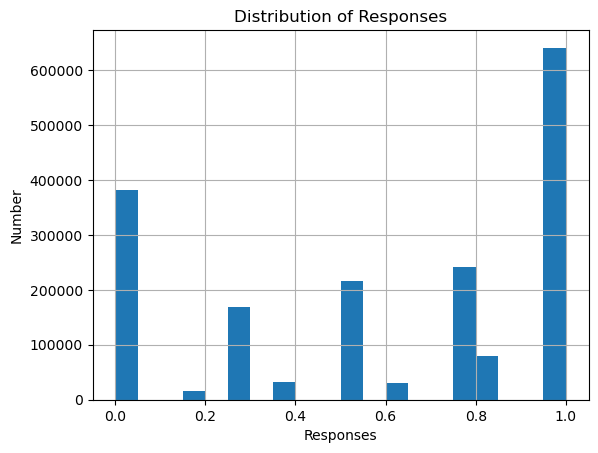

In [25]:
import matplotlib.pyplot as plt

# draw a histogram of the age column
(scaled_data['correct']-1).hist(bins=20)

# add labels and title
plt.xlabel('Responses')
plt.ylabel('Number')
plt.title('Distribution of Responses')
plt.savefig('../4-figs/distribution_promis.png')


In [27]:
scaled_data_dim_grouped_items = scaled_data.groupby("item_id")["dimension_id"].nunique()
scaled_data_dim_grouped_users = scaled_data.groupby("item_id")["user_id"].nunique()
metadata = get_metadata(scaled_data,["user_id", "item_id", "dimension_id"])
metadata['min_nb_users_logs'] = min_nb_users_logs
metadata['max_nb_categories_per_question'] = int(np.max(scaled_data_dim_grouped_items))
metadata['max_nb_questions_per_user'] = int(max_nb_q_per_users)

### Compute nb of modalities per item

In [28]:
nb_modalities = get_modalities_nb(scaled_data, metadata)

### Save data, concept map, metadata and nb_modalities

In [29]:
new_order = ['user_id','item_id', 'correct', 'dimension_id']
resc_data = scaled_data[new_order]

In [30]:
# save selected data
resc_data.to_csv('../1-raw_data/promis_selected_data.csv', index=False)

In [31]:
# Convert int64 keys to str
q2k_str_keys = {str(key): value for key, value in q2k.items()}

# Convert sets to lists in the dictionary
q2k_json_serializable = {}
for key, value in q2k_str_keys.items():
    if isinstance(value, set):
        q2k_json_serializable[key] = list(value)
    else:
        q2k_json_serializable[key] = value

# Save concept map
with open('../2-preprocessed_data/promis_concept_map.json', 'w') as f:
    json.dump(q2k_json_serializable, f)

In [32]:
# save metadata
with open('../2-preprocessed_data/promis_metadata.json', 'w') as f:
    json.dump(metadata, f)

In [33]:
# save metadata
torch.save(nb_modalities,'../2-preprocessed_data/promis_nb_modalities.pkl')

In [34]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [35]:
from liriscat import utils
utils.setuplogger(verbose = True,log_path = "../../logs/", log_name="liriscat")
utils.set_seed(0)

CUDA is not available. Skipping CUDA seed setting.


In [36]:
import pandas as pd
from liriscat.dataset.preprocessing_utilities import *
resc_data = pd.read_csv('../1-raw_data/promis_selected_data.csv')

In [37]:
train, valid, test = split_users(resc_data, 5)

## save data

In [ ]:
for i_fold, train_fold in enumerate(train):
    save_df_to_csv(train[i_fold], f'../2-preprocessed_data/promis_train_{i_fold}.csv')
    save_df_to_csv(valid[i_fold], f'../2-preprocessed_data/promis_valid_{i_fold}.csv')
    save_df_to_csv(test[i_fold], f'../2-preprocessed_data/promis_test_{i_fold}.csv')

    train_valid_df = pd.concat([train[i_fold], valid[i_fold]])
    # Split the merged data horizontally into train and validation sets.

    quadruplet = quadruplet_format(train_valid_df)
    vertical_train, vertical_valid = split_data_vertically_unique_fold(quadruplet, valid_prop=0.1)

    save_df_to_csv(vertical_train, f'../2-preprocessed_data/promis_vert_train_{i_fold}.csv')
    save_df_to_csv(vertical_valid, f'../2-preprocessed_data/promis_vert_valid_{i_fold}.csv')